In [51]:
import util as ut
import numpy as np
import os
import jams
import librosa
import matplotlib.pyplot as plt
import madmom

## Get Key Test Set: GSKey

In [3]:
p = '/scratch/qx244/data/gskey/augmentation'
file_list = ut.glob(os.path.join(p, '*.npy'))
print(len(file_list))

6612


In [4]:
madmom.features.key.KEY_LABELS

['A major',
 'Bb major',
 'B major',
 'C major',
 'Db major',
 'D major',
 'Eb major',
 'E major',
 'F major',
 'F# major',
 'G major',
 'Ab major',
 'A minor',
 'Bb minor',
 'B minor',
 'C minor',
 'C# minor',
 'D minor',
 'D# minor',
 'E minor',
 'F minor',
 'F# minor',
 'G minor',
 'G# minor']

In [5]:
pred_list = []
label_list = []
for f in file_list:
    jams_path = f.rsplit('.', 1)[0] + '.jams'
    pred_list.append(np.load(f))
    jam = jams.load(jams_path)
    tonic = jam.search(namespace='key_mode')[0].to_dataframe().value[0]
    label_list.append((librosa.note_to_midi(tonic)) % 12)

pred_all = np.concatenate(pred_list, axis=0)
label_all = (np.array(label_list) + 3) % 12 # So that bin 0 is A to match with madmom

In [6]:
pred_all.shape

(6612, 24)

We want to minimize the follwing quantity:

In [11]:
from scipy.optimize import minimize_scalar

### 1. raise to the beta first then marginalize

In [68]:
def madmom_track_nll(beta, tc_labels, madmom_out):
    """ just summing frame_nll across the whole track
    Param:
        beta: inverse temp < 0
        tc_labels: vector of tonal center labels, with 0 being A
        madmom_out: matrix with shape N x 24
    Returns:
        Aggregated frame_nll
    """
    madmom_q = madmom_out ** beta
    madmom_q /= np.sum(madmom_q, axis=1, keepdims=True)
    tc_q = madmom_q[:, :12] + madmom_q[:, 12:]
    
    per_frame_nll = -np.log(np.take_along_axis(tc_q, tc_labels[:, np.newaxis], axis=1))
    return np.mean(per_frame_nll)

def madmom_calib(beta, madmom_out):
    madmom_q = madmom_out ** beta
    madmom_q /= np.sum(madmom_q, axis=1, keepdims=True)
    tc_q = madmom_q[:, :12] + madmom_q[:, 12:]
    return tc_q

In [69]:
res = minimize_scalar(madmom_track_nll, 
                      args=(label_all, pred_all),
                      bounds=(0, 2),
                      method='bounded')

In [70]:
res

     fun: 0.5319866913805712
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 1.1939114525258065

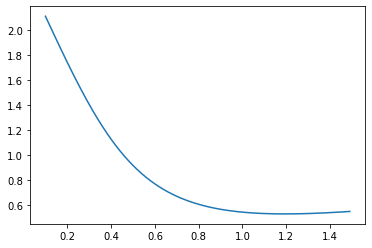

In [71]:
plt.plot(np.arange(0.1, 1.5, 0.01),
         [madmom_track_nll(b, label_all, pred_all) 
          for b in np.arange(0.1, 1.5, 0.01)])

In [72]:
def plot_compare_eces(p_bench, q_bench):
    bins = np.linspace(0, 1, num=15, endpoint=True)
    plt.figure(figsize=(12,8))
    plt.plot(bins, p_bench.bin_accuracy(), 'r:')
    plt.plot(bins, q_bench.bin_accuracy(), 'g-')
    plt.plot(bins, bins, 'k')
    plt.xlabel('perdiction confidence')
    plt.ylabel('average accuracy')
    plt.show()

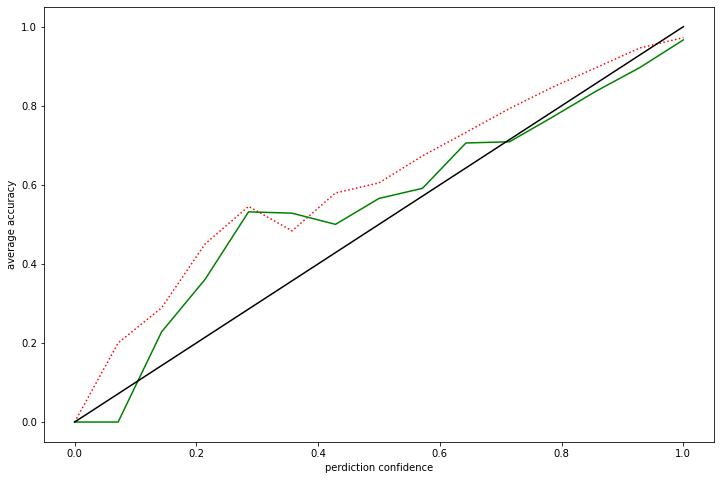

In [73]:
p = madmom_calib(1, pred_all)
q = madmom_calib(res.x, pred_all)
p_bench = ut.CalibrationBenchmark(p, label_all)
q_bench = ut.CalibrationBenchmark(q, label_all)
plot_compare_eces(p_bench, q_bench)

In [74]:
p_bench.ece()

0.057454659563644817

In [75]:
q_bench.ece()

0.030261222661164107

### 2. Marginalize then raise to the beta

In [76]:
def add_track_nll(beta, tc_labels, madmom_out):
    """ just summing frame_nll across the whole track
    Param:
        beta: inverse temp < 0
        tc_labels: vector of tonal center labels, with 0 being A
        madmom_out: matrix with shape N x 24
    Returns:
        Aggregated frame_nll
    """
    tc = madmom_out[:, :12] + madmom_out[:, 12:]
    tc_q = tc ** beta
    tc_q /= np.sum(tc_q, axis=1, keepdims=True)
    
    per_frame_nll = -np.log(np.take_along_axis(tc_q, tc_labels[:, np.newaxis], axis=1))
    return np.mean(per_frame_nll)

def add_calib(beta, madmom_out):
    tc = madmom_out[:, :12] + madmom_out[:, 12:]
    tc_q = tc ** beta
    tc_q /= np.sum(tc_q, axis=1, keepdims=True)
    return tc_q

In [77]:
res = minimize_scalar(add_track_nll, 
                      args=(label_all, pred_all),
                      bounds=(0, 2),
                      method='bounded')

In [95]:
res_a = minimize_scalar(add_track_nll, 
                      args=(label_all, pred_all),
                      bounds=(0, 1),
                      method='bounded')

In [96]:
res_a

     fun: 0.5460690846128482
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.9999941325303439

In [78]:
res

     fun: 0.5321072002952393
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 1.206828490321766

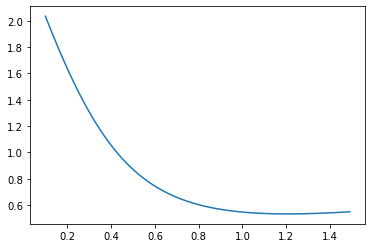

In [79]:
plt.plot(np.arange(0.1, 1.5, 0.01),
         [add_track_nll(b, label_all, pred_all) 
          for b in np.arange(0.1, 1.5, 0.01)])

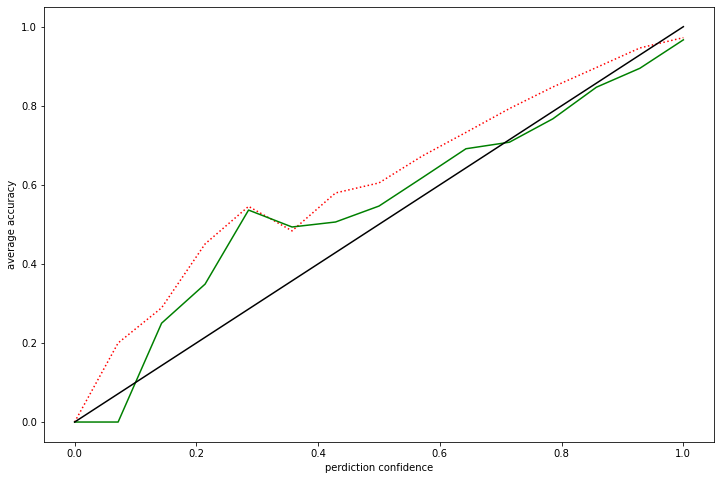

In [80]:
p = add_calib(1, pred_all)
q = add_calib(res.x, pred_all)
p_bench = ut.CalibrationBenchmark(p, label_all)
q_bench = ut.CalibrationBenchmark(q, label_all)
plot_compare_eces(p_bench, q_bench)

In [81]:
p_bench.ece()

0.057454659563644817

In [82]:
q_bench.ece()

0.02997769521605532

## 3. marginalize first andwith AND, same as adding logits

In [83]:
def logit_track_nll(beta, tc_labels, madmom_out):
    """ just summing frame_nll across the whole track
    Param:
        beta: inverse temp < 0
        tc_labels: vector of tonal center labels, with 0 being A
        madmom_out: matrix with shape N x 24
    Returns:
        Aggregated frame_nll
    """
    tc = madmom_out[:, :12] * madmom_out[:, 12:]
    tc /= np.sum(tc, axis=1, keepdims=True)
    tc_q = tc ** beta
    tc_q /= np.sum(tc_q, axis=1, keepdims=True)
    
    per_frame_nll = -np.log(np.take_along_axis(tc_q, tc_labels[:, np.newaxis], axis=1))
    return np.mean(per_frame_nll)

def logit_calib(beta, madmom_out):
    tc = madmom_out[:, :12] * madmom_out[:, 12:]
    tc /= np.sum(tc, axis=1, keepdims=True)
    tc_q = tc ** beta
    tc_q /= np.sum(tc_q, axis=1, keepdims=True)
    return tc_q

In [84]:
res = minimize_scalar(logit_track_nll, 
                      args=(label_all, pred_all),
                      bounds=(0, 2),
                      method='bounded')

In [85]:
res

     fun: 0.5278569629523883
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.7806338431868136

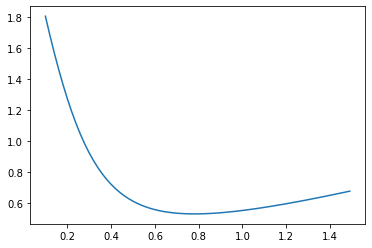

In [86]:
plt.plot(np.arange(0.1, 1.5, 0.01),
         [logit_track_nll(b, label_all, pred_all) 
          for b in np.arange(0.1, 1.5, 0.01)])

In [ ]:
p = logit_calib(1, pred_all)
q = logit_calib(res.x, pred_all)
p_bench = ut.CalibrationBenchmark(p, label_all)
q_bench = ut.CalibrationBenchmark(q, label_all)
plot_compare_eces(p_bench, q_bench)

In [106]:
p_bench.ece()

0.04822095747507236

In [88]:
q_bench.ece()

0.01780341704796239

## 4. raise to the beta first and then marginalize with AND

In [89]:
def prelogit_track_nll(beta, tc_labels, madmom_out):
    """ just summing frame_nll across the whole track
    Param:
        beta: inverse temp < 0
        tc_labels: vector of tonal center labels, with 0 being A
        madmom_out: matrix with shape N x 24
    Returns:
        Aggregated frame_nll
    """
    madmom_q = madmom_out ** beta
    madmom_q /= np.sum(madmom_q, axis=1, keepdims=True)
    tc_q = madmom_q[:, :12] * madmom_q[:, 12:]
    tc_q /= np.sum(tc_q, axis=1, keepdims=True)
    
    per_frame_nll = -np.log(np.take_along_axis(tc_q, tc_labels[:, np.newaxis], axis=1))
    return np.mean(per_frame_nll)

def prelogit_calib(beta, madmom_out):
    madmom_q = madmom_out ** beta
    madmom_q /= np.sum(madmom_q, axis=1, keepdims=True)
    tc_q = madmom_q[:, :12] * madmom_q[:, 12:]
    tc_q /= np.sum(tc_q, axis=1, keepdims=True)
    return tc_q

In [90]:
res = minimize_scalar(prelogit_track_nll, 
                      args=(label_all, pred_all),
                      bounds=(0, 2),
                      method='bounded')

In [91]:
res

     fun: 0.5278569629523883
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.7806338431868142

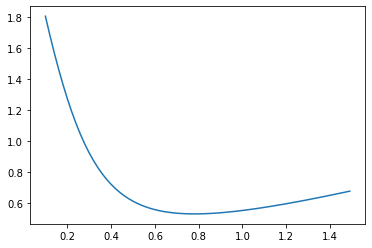

In [92]:
plt.plot(np.arange(0.1, 1.5, 0.01),
         [prelogit_track_nll(b, label_all, pred_all) 
          for b in np.arange(0.1, 1.5, 0.01)])

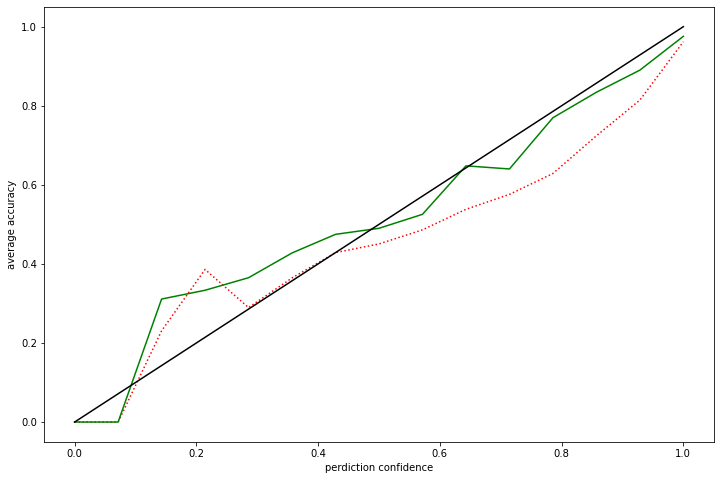

In [93]:
p = prelogit_calib(1, pred_all)
q = prelogit_calib(res.x, pred_all)
p_bench = ut.CalibrationBenchmark(p, label_all)
q_bench = ut.CalibrationBenchmark(q, label_all)
plot_compare_eces(p_bench, q_bench)

In [94]:
q_bench.ece()

0.017803417047962438

## 5. True Gemometric mean

In [103]:
def geom_track_nll(beta, tc_labels, madmom_out):
    """ just summing frame_nll across the whole track
    Param:
        beta: inverse temp < 0
        tc_labels: vector of tonal center labels, with 0 being A
        madmom_out: matrix with shape N x 24
    Returns:
        Aggregated frame_nll
    """
    madmom_q = madmom_out ** beta
    madmom_q /= np.sum(madmom_q, axis=1, keepdims=True)
    tc_q = np.sqrt(madmom_q[:, :12] * madmom_q[:, 12:])
    tc_q /= np.sum(tc_q, axis=1, keepdims=True)
    
    per_frame_nll = -np.log(np.take_along_axis(tc_q, tc_labels[:, np.newaxis], axis=1))
    return np.mean(per_frame_nll)

def geom_calib(beta, madmom_out):
    madmom_q = madmom_out ** beta
    madmom_q /= np.sum(madmom_q, axis=1, keepdims=True)
    tc_q = np.sqrt(madmom_q[:, :12] * madmom_q[:, 12:])
    tc_q /= np.sum(tc_q, axis=1, keepdims=True)
    return tc_q

In [104]:
res = minimize_scalar(geom_track_nll, 
                      args=(label_all, pred_all),
                      bounds=(0, 2),
                      method='bounded')

In [105]:
res

     fun: 0.5278569629522144
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 1.5612663968691582

## inspect the madmom prediction matrix

In [52]:
pred_all.shape

(6612, 24)

In [53]:
pred_max = np.max(pred_all, axis=1)

In [57]:
np.mean(pred_max)

0.7548270881759206

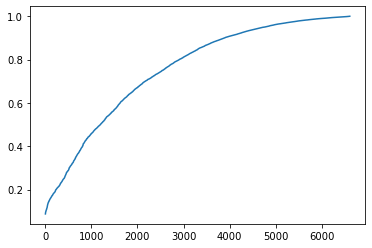

In [59]:
plt.plot(np.sort(pred_max))

(array([ 166.,  281.,  245.,  285.,  405.,  414.,  571.,  691.,  960.,
        2594.]),
 array([0.08810271, 0.1792698 , 0.27043689, 0.36160398, 0.45277107,
        0.54393816, 0.63510525, 0.72627234, 0.81743943, 0.90860652,
        0.99977361]),
 <BarContainer object of 10 artists>)

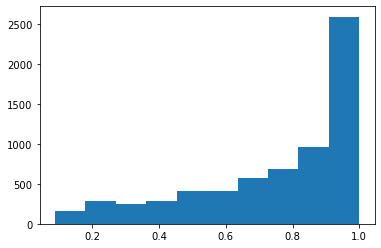

In [60]:
plt.hist(pred_max)

In [109]:
q_max = np.max(logit_calib(0.7806338431868136, pred_all), axis=1)

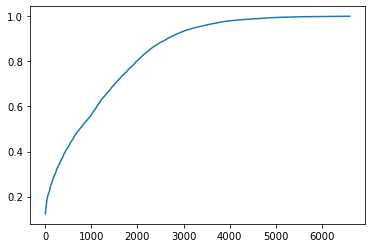

In [110]:
plt.plot(np.sort(q_max))

(array([  65.,  143.,  191.,  251.,  342.,  309.,  374.,  433.,  655.,
        3849.]),
 array([0.12347696, 0.21112761, 0.29877825, 0.3864289 , 0.47407955,
        0.56173019, 0.64938084, 0.73703148, 0.82468213, 0.91233277,
        0.99998342]),
 <BarContainer object of 10 artists>)

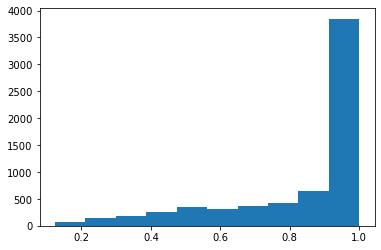

In [111]:
plt.hist(q_max)

In [115]:
q_add_max = np.max(madmom_calib(1.1939114525258065, pred_all), axis=1)

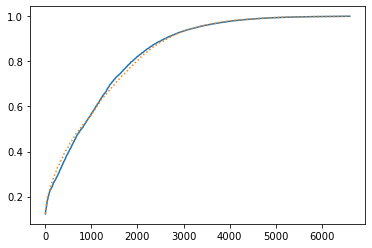

In [118]:
plt.plot(np.sort(q_add_max))
plt.plot(np.sort(q_max), ':')

(array([  77.,  198.,  195.,  223.,  288.,  271.,  325.,  448.,  701.,
        3886.]),
 array([0.12337058, 0.21103193, 0.29869328, 0.38635462, 0.47401597,
        0.56167731, 0.64933866, 0.73700001, 0.82466135, 0.9123227 ,
        0.99998405]),
 <BarContainer object of 10 artists>)

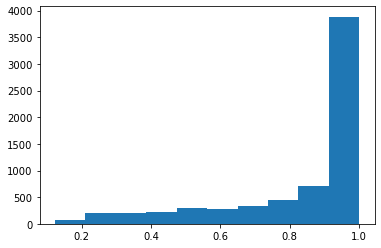

In [117]:
plt.hist(q_add_max)

In [119]:
pred_maj = pred_all[: , :12]
pred_min = pred_all[: , 12:]

In [120]:
key_maj = np.argmax(pred_maj, axis = 1)
key_min = np.argmax(pred_min, axis=1)

(array([3643.,   25.,    6., 2112.,   14.,  128.,   10.,   90.,  230.,
           6.,  335.,   13.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <BarContainer object of 12 artists>)

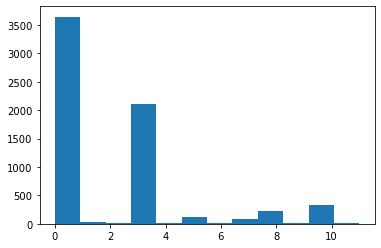

In [125]:
diff = (key_maj - key_min) % 12
plt.hist(diff, bins=12)